# 编程作业 7 - K-means 和PCA（主成分分析）

在本练习中，我们将实现K-means聚类，并使用它来压缩图像。 我们将从一个简单的2D数据集开始，以了解K-means是如何工作的，然后我们将其应用于图像压缩。 我们还将对主成分分析进行实验，并了解如何使用它来找到面部图像的低维表示。

## K-means 聚类

我们将实施和应用K-means到一个简单的二维数据集，以获得一些直观的工作原理。 K-means是一个迭代的，无监督的聚类算法，将类似的实例组合成簇。 该算法通过猜测每个簇的初始聚类中心开始，然后重复将实例分配给最近的簇，并重新计算该簇的聚类中心。 我们要实现的第一部分是找到数据中每个实例最接近的聚类中心的函数。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat


In [2]:
def find_closest_centroids(X, centroids):
# INPUT：数据X，初始聚类中心centroids
# OUTPUT：距离聚类中心最近的数据索引
# TODO：找到数据中每个实例最接近的聚类中心的数据
    
    # STEP1：得到矩阵的维度，初始化矩阵
    m = X.shape[0]
    k = centroids.shape[0]
    idx = np.zeros(m)
    
    # STEP2：遍历所有数据，找到距离聚类中心最近的
    # your code here  (appro ~ 3 lines)
    for i in range(m):
        min_dist = 1000000
        for j in range(k):
            dist = np.sum((X[i,:] - centroids[j,:]) ** 2)
            if dist < min_dist:
                # 记录当前最短距离和中心索引值
                min_dist = dist
                idx[i] = j
                
    return idx

让我们来测试这个函数，以确保它的工作正常。 我们将使用练习中提供的测试用例。

In [3]:
data = loadmat('data/ex7data2.mat')
X = data['X']
initial_centroids = initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])

idx = find_closest_centroids(X, initial_centroids)
idx[0:3]

array([0., 2., 1.])

输出与文本中的预期值匹配（记住我们的数组是从零开始索引的，而不是从一开始索引的，所以值比练习中的值低一个）。 接下来，我们需要一个函数来计算簇的聚类中心。 聚类中心只是当前分配给簇的所有样本的平均值。

In [4]:
data2 = pd.DataFrame(data.get('X'), columns=['X1', 'X2'])
data2.head()

,X1,X2
0,1.842080,4.607572
1,5.658583,4.799964
2,6.352579,3.290854
3,2.904017,4.612204
4,3.231979,4.939894


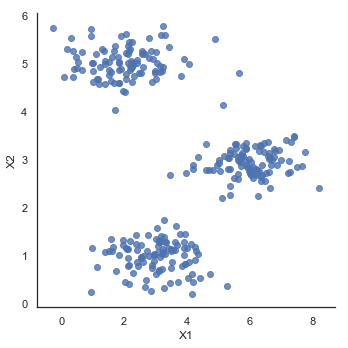

In [5]:
sb.set(context="notebook", style="white")
sb.lmplot('X1', 'X2', data=data2, fit_reg=False)
plt.show()

In [6]:
def compute_centroids(X, idx, k):
# INPUT：数据X，聚类中心idx，簇的个数k
# OUTPUT：当前簇的聚类中心
# TODO：计算当前簇的聚类中心
    # STEP1：得到矩阵大小，初始化矩阵
    m, n = X.shape
    centroids = np.zeros((k, n))
    
    # STEP2：计算聚类中心
    # your code here  (appro ~ 2 lines)
    for i in range(k):
        indices =  np.where(idx == i)
        centroids[i,:] = (np.sum(X[indices,:], axis=1) / len(indices[0])).ravel()
    
    return centroids

In [7]:
compute_centroids(X, idx, 3)

array([[2.42830111, 3.15792418],
       [5.81350331, 2.63365645],
       [7.11938687, 3.6166844 ]])

如果你的答案正确，这里的输出应该是：
array([[ 2.42830111,  3.15792418],
       [ 5.81350331,  2.63365645],
       [ 7.11938687,  3.6166844 ]])
       
 

此输出也符合练习中的预期值。 
下一部分涉及实际运行该算法的一些迭代次数和可视化结果。 
这个步骤是由于并不复杂，我将从头开始构建它。 为了运行算法，我们只需要在将样本分配给最近的簇并重新计算簇的聚类中心。

In [8]:
def run_k_means(X, initial_centroids, max_iters):
# INPUT：数据X，聚类中心idx，簇的个数k
# OUTPUT：当前簇的聚类中心
# TODO：计算当前簇的聚类中心
    # STEP1：得到矩阵大小，初始化矩阵级变量
    m, n = X.shape
    k = initial_centroids.shape[0]
    idx = np.zeros(m)
    centroids = initial_centroids
    # STEP2：实施聚类算法，调用之前的两个函数
    # your code here  (appro ~ 2 lines)    
    for i in range(max_iters):
        idx = find_closest_centroids(X, centroids)
        centroids = compute_centroids(X, idx, k)
    
    return idx, centroids

In [9]:
idx, centroids = run_k_means(X, initial_centroids, 10)

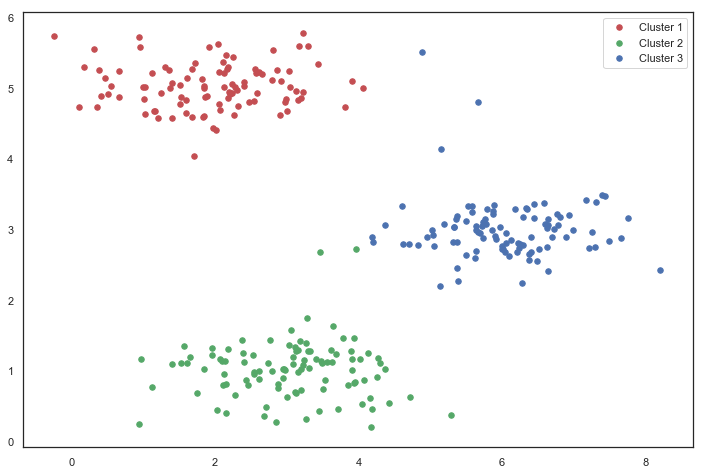

In [10]:
cluster1 = X[np.where(idx == 0)[0],:]
cluster2 = X[np.where(idx == 1)[0],:]
cluster3 = X[np.where(idx == 2)[0],:]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(cluster1[:,0], cluster1[:,1], s=30, color='r', label='Cluster 1')
ax.scatter(cluster2[:,0], cluster2[:,1], s=30, color='g', label='Cluster 2')
ax.scatter(cluster3[:,0], cluster3[:,1], s=30, color='b', label='Cluster 3')
ax.legend()
plt.show()

我们跳过的一个步骤是初始化聚类中心的过程。 这可以影响算法的收敛。实际上对于二维以上的数据，由于无法在平面坐标轴展示，很难一开始就设定较好的初始质心，另外，初始质心的设定也可能会影响算法的收敛性。所以我们的任务是创建一个选择随机样本并将其用作初始聚类中心的函数。

In [11]:
def init_centroids(X, k):
    m, n = X.shape
    centroids = np.zeros((k, n))
    idx = np.random.randint(0, m, k)
    
    for i in range(k):
        centroids[i,:] = X[idx[i],:]
    
    return centroids

In [12]:
init_centroids(X, 3)

array([[3.7875723 , 1.45442904],
       [5.50295759, 2.62924634],
       [3.00677254, 0.62519128]])

我们的下一个任务是将K-means应用于图像压缩。 从下面的演示可以看到，我们可以使用聚类来找到最具代表性的少数颜色，并使用聚类分配将原始的24位颜色映射到较低维的颜色空间。 

下面是我们要压缩的图像。

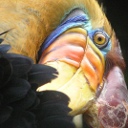

In [13]:
from IPython.display import Image
Image(filename='data/bird_small.png')

The raw pixel data has been pre-loaded for us so let's pull it in.

In [14]:
image_data = loadmat('data/bird_small.mat')
image_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue Jun  5 04:06:24 2012',
 '__version__': '1.0',
 '__globals__': [],
 'A': array([[[219, 180, 103],
         [230, 185, 116],
         [226, 186, 110],
         ...,
         [ 14,  15,  13],
         [ 13,  15,  12],
         [ 12,  14,  12]],
 
        [[230, 193, 119],
         [224, 192, 120],
         [226, 192, 124],
         ...,
         [ 16,  16,  13],
         [ 14,  15,  10],
         [ 11,  14,   9]],
 
        [[228, 191, 123],
         [228, 191, 121],
         [220, 185, 118],
         ...,
         [ 14,  16,  13],
         [ 13,  13,  11],
         [ 11,  15,  10]],
 
        ...,
 
        [[ 15,  18,  16],
         [ 18,  21,  18],
         [ 18,  19,  16],
         ...,
         [ 81,  45,  45],
         [ 70,  43,  35],
         [ 72,  51,  43]],
 
        [[ 16,  17,  17],
         [ 17,  18,  19],
         [ 20,  19,  20],
         ...,
         [ 80,  38,  40],
         [ 68,  39,  40],
     

In [15]:
A = image_data['A']
A.shape

(128, 128, 3)

现在我们需要对数据应用一些预处理，并将其提供给K-means算法。

In [16]:
# 归一化数据
A = A / 255.

# 重置矩阵大小
X = np.reshape(A, (A.shape[0] * A.shape[1], A.shape[2]))
X.shape

(16384, 3)

In [17]:
# 随机初始化聚类中心
initial_centroids = init_centroids(X, 16)

# 运行之前写好的聚类算法
idx, centroids = run_k_means(X, initial_centroids, 10)

# 得到最后一个聚类中心
idx = find_closest_centroids(X, centroids)

# 把每一个像素值与聚类结果进行匹配
X_recovered = centroids[idx.astype(int),:]
X_recovered.shape

(16384, 3)

In [18]:
# reshape to the original dimensions
X_recovered = np.reshape(X_recovered, (A.shape[0], A.shape[1], A.shape[2]))
X_recovered.shape

(128, 128, 3)

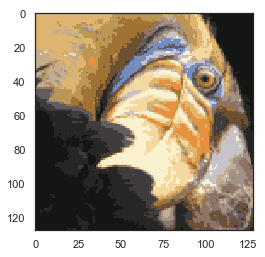

In [19]:
plt.imshow(X_recovered)
plt.show()

您可以看到我们对图像进行了压缩，但图像的主要特征仍然存在。 这就是K-means。 下面我们来用scikit-learn来实现K-means。

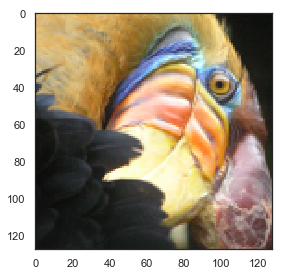

In [20]:
from skimage import io

pic = io.imread('data/bird_small.png') / 255.
io.imshow(pic)
plt.show()

In [21]:
pic.shape

(128, 128, 3)

In [22]:
# 重置图像大小
data = pic.reshape(128*128, 3)

In [23]:
data.shape

(16384, 3)

In [24]:
from sklearn.cluster import KMeans#导入k-means库

model = KMeans(n_clusters=16, n_init=100, n_jobs=-1)

In [25]:
model.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=16, n_init=100, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [26]:
centroids = model.cluster_centers_
print(centroids.shape)

C = model.predict(data)
print(C.shape)

(16, 3)
(16384,)


In [27]:
centroids[C].shape

(16384, 3)

In [28]:
compressed_pic = centroids[C].reshape((128,128,3))

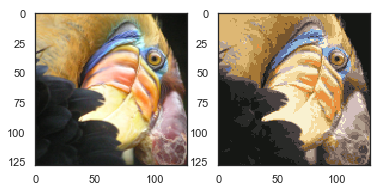

In [29]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(pic)
ax[1].imshow(compressed_pic)
plt.show()

## Principal component analysis（主成分分析）

PCA是在数据集中找到“主成分”或最大方差方向的线性变换。 它可以用于降维。 在本练习中，我们首先负责实现PCA并将其应用于一个简单的二维数据集，以了解它是如何工作的。 我们从加载和可视化数据集开始。

In [30]:
data = loadmat('data/ex7data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Nov 14 22:41:44 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[3.38156267, 3.38911268],
        [4.52787538, 5.8541781 ],
        [2.65568187, 4.41199472],
        [2.76523467, 3.71541365],
        [2.84656011, 4.17550645],
        [3.89067196, 6.48838087],
        [3.47580524, 3.63284876],
        [5.91129845, 6.68076853],
        [3.92889397, 5.09844661],
        [4.56183537, 5.62329929],
        [4.57407171, 5.39765069],
        [4.37173356, 5.46116549],
        [4.19169388, 4.95469359],
        [5.24408518, 4.66148767],
        [2.8358402 , 3.76801716],
        [5.63526969, 6.31211438],
        [4.68632968, 5.6652411 ],
        [2.85051337, 4.62645627],
        [5.1101573 , 7.36319662],
        [5.18256377, 4.64650909],
        [5.70732809, 6.68103995],
        [3.57968458, 4.80278074],
        [5.63937773, 6.12043594],
        [4.26346851, 4.68942896],
        [2.53651693, 3.88449078],
      

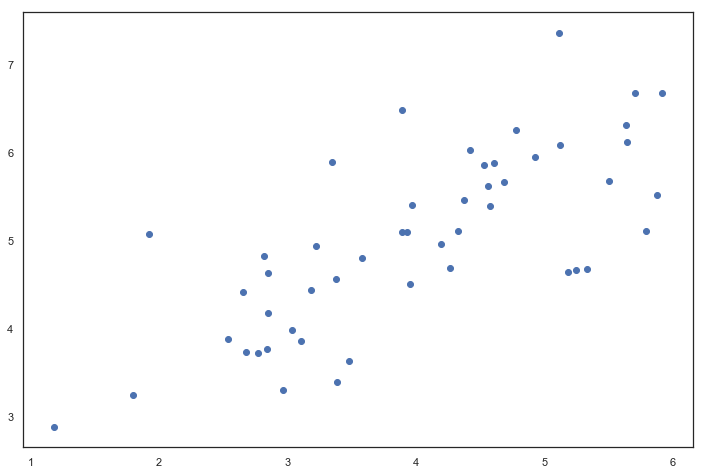

In [31]:
X = data['X']

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:, 0], X[:, 1])
plt.show()

PCA的算法相当简单。 在确保数据被归一化之后，输出仅仅是原始数据的协方差矩阵的奇异值分解。
Tip：矩阵奇异值分解可以使用np.linalg.svd(X)函数，其中X是待分解矩阵。

In [32]:
def pca(X):
# INPUT：数据X
# OUTPUT：矩阵U，S，V
# TODO：对数据进行奇异值分解
    # STEP1：归一化数据
    # your code here  (appro ~ 1 lines)
    X = (X - X.mean()) / X.std()
    
    # STEP2：计算协方差矩阵
    # your code here  (appro ~ 2 lines)  
    X = np.matrix(X)
    cov =(X.T * X) / X.shape[0]
    
    # STEP3：进行奇异值分解
    # your code here  (appro ~ 1 lines)  
    U, S, V = np.linalg.svd(cov)
    
    return U, S, V

In [33]:
U, S, V = pca(X)
U, S, V

(matrix([[-0.79241747, -0.60997914],
         [-0.60997914,  0.79241747]]),
 array([1.43584536, 0.56415464]),
 matrix([[-0.79241747, -0.60997914],
         [-0.60997914,  0.79241747]]))

现在我们有主成分（矩阵U），我们可以用这些来将原始数据投影到一个较低维的空间中。 对于这个任务，我们将实现一个计算投影并且仅选择顶部K个分量的函数，有效地减少了维数。

In [34]:
def project_data(X, U, k):
    U_reduced = U[:,:k]
    return np.dot(X, U_reduced)

In [35]:
Z = project_data(X, U, 1)
Z

matrix([[-4.74689738],
        [-7.15889408],
        [-4.79563345],
        [-4.45754509],
        [-4.80263579],
        [-7.04081342],
        [-4.97025076],
        [-8.75934561],
        [-6.2232703 ],
        [-7.04497331],
        [-6.91702866],
        [-6.79543508],
        [-6.3438312 ],
        [-6.99891495],
        [-4.54558119],
        [-8.31574426],
        [-7.16920841],
        [-5.08083842],
        [-8.54077427],
        [-6.94102769],
        [-8.5978815 ],
        [-5.76620067],
        [-8.2020797 ],
        [-6.23890078],
        [-4.37943868],
        [-5.56947441],
        [-7.53865023],
        [-7.70645413],
        [-5.17158343],
        [-6.19268884],
        [-6.24385246],
        [-8.02715303],
        [-4.81235176],
        [-7.07993347],
        [-5.45953289],
        [-7.60014707],
        [-4.39612191],
        [-7.82288033],
        [-3.40498213],
        [-6.54290343],
        [-7.17879573],
        [-5.22572421],
        [-4.83081168],
        [-7

我们也可以通过反向转换步骤来恢复原始数据。

In [36]:
def recover_data(Z, U, k):
    U_reduced = U[:,:k]
    return np.dot(Z, U_reduced.T)

In [37]:
X_recovered = recover_data(Z, U, 1)
X_recovered

matrix([[3.76152442, 2.89550838],
        [5.67283275, 4.36677606],
        [3.80014373, 2.92523637],
        [3.53223661, 2.71900952],
        [3.80569251, 2.92950765],
        [5.57926356, 4.29474931],
        [3.93851354, 3.03174929],
        [6.94105849, 5.3430181 ],
        [4.93142811, 3.79606507],
        [5.58255993, 4.29728676],
        [5.48117436, 4.21924319],
        [5.38482148, 4.14507365],
        [5.02696267, 3.8696047 ],
        [5.54606249, 4.26919213],
        [3.60199795, 2.77270971],
        [6.58954104, 5.07243054],
        [5.681006  , 4.37306758],
        [4.02614513, 3.09920545],
        [6.76785875, 5.20969415],
        [5.50019161, 4.2338821 ],
        [6.81311151, 5.24452836],
        [4.56923815, 3.51726213],
        [6.49947125, 5.00309752],
        [4.94381398, 3.80559934],
        [3.47034372, 2.67136624],
        [4.41334883, 3.39726321],
        [5.97375815, 4.59841938],
        [6.10672889, 4.70077626],
        [4.09805306, 3.15455801],
        [4.907

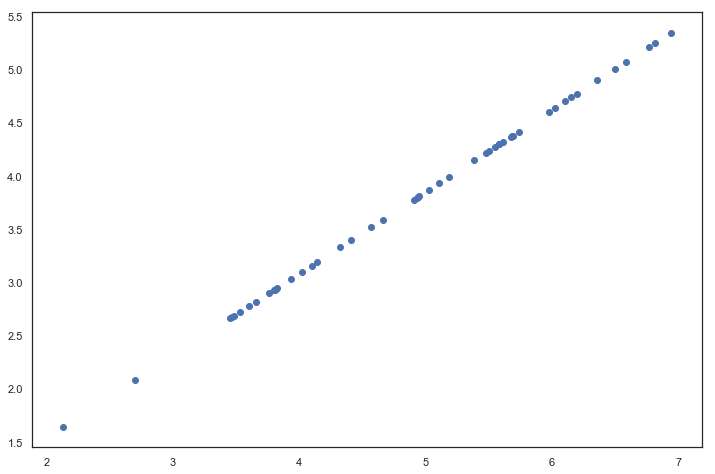

In [38]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(list(X_recovered[:, 0]), list(X_recovered[:, 1]))
plt.show()

请注意，第一主成分的投影轴基本上是数据集中的对角线。 当我们将数据减少到一个维度时，我们失去了该对角线周围的变化，所以在我们的再现中，一切都沿着该对角线。

我们在此练习中的最后一个任务是将PCA应用于脸部图像。 通过使用相同的降维技术，我们可以使用比原始图像少得多的数据来捕获图像的“本质”。

In [39]:
faces = loadmat('data/ex7faces.mat')
X = faces['X']
X.shape

(5000, 1024)

In [40]:
def plot_n_image(X, n):
    """ plot first n images
    n has to be a square number
    """
    pic_size = int(np.sqrt(X.shape[1]))
    grid_size = int(np.sqrt(n))

    first_n_images = X[:n, :]

    fig, ax_array = plt.subplots(nrows=grid_size, ncols=grid_size,
                                    sharey=True, sharex=True, figsize=(8, 8))

    for r in range(grid_size):
        for c in range(grid_size):
            ax_array[r, c].imshow(first_n_images[grid_size * r + c].reshape((pic_size, pic_size)))
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))


练习代码包括一个将渲染数据集中的前100张脸的函数。 而不是尝试在这里重新生成，您可以在练习文本中查看他们的样子。 我们至少可以很容易地渲染一个图像。

In [41]:
face = np.reshape(X[3,:], (32, 32))

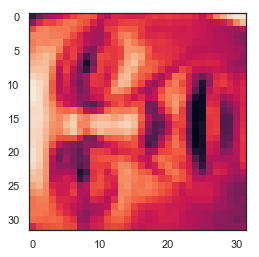

In [42]:
plt.imshow(face)
plt.show()

看起来很糟糕。 这些只有32 x 32灰度的图像（它也是侧面渲染，但我们现在可以忽略）。 我们的下一步是在面数据集上运行PCA，并取得前100个主要特征。

In [43]:
U, S, V = pca(X)
Z = project_data(X, U, 100)

现在我们可以尝试恢复原来的结构并再次渲染。

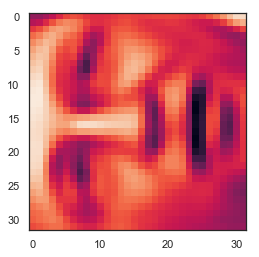

In [44]:
X_recovered = recover_data(Z, U, 100)
face = np.reshape(X_recovered[3,:], (32, 32))
plt.imshow(face)
plt.show()

请注意，我们失去了一些细节，尽管没有像您预期的维度数量减少10倍。
